In [344]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroplan import Observer, FixedTarget
from astropy.time import Time
from astropy.table import Table

In [345]:
SUTHERLAND_OBSERVATORY = Observer.at_site("salt")

# Get the current date
current_date = Time.now()

# Define the time for 6 PM UTC today
time_window_start = Time(current_date.iso.split(" ")[0] + " 18:00:00")


# Define the time range in three seperate time blocks from 6 PM today to 6 AM UTC tomorrow 
time_range_early = Time([time_window_start, time_window_start + 3 * u.hour])
time_range_mid = Time([time_window_start + 3 * u.hour, time_window_start + 6 * u.hour])
time_range_late = Time([time_window_start + 6 * u.hour, time_window_start + 9 * u.hour])

# Print the time range
print(r'Current time (UTC): {}'.format(current_date))
print(time_range_early)
print(time_range_mid)
print(time_range_late)

Current time (UTC): 2024-05-01 17:37:46.684387
['2024-05-01 18:00:00.000' '2024-05-01 21:00:00.000']
['2024-05-01 21:00:00.000' '2024-05-02 00:00:00.000']
['2024-05-02 00:00:00.000' '2024-05-02 03:00:00.000']


In [346]:
eso_spectroscopic_standard_stars = Table.read(
    "eso_ra_ordered_spectrosopic_standards.txt", format="csv"
)

filtered_spectroscopic_standard_stars = eso_spectroscopic_standard_stars[
    eso_spectroscopic_standard_stars["visual_mag"] <= 11
]

filtered_spectral_standards_targets = [
    FixedTarget(coord=SkyCoord(ra_dec, unit=(u.hourangle, u.deg)), name=name)
    for name, ra_dec, visual_mag, spec_type, note in filtered_spectroscopic_standard_stars
]

print(filtered_spectroscopic_standard_stars)

   name         ra_dec_(J2000)     visual_mag spec_type Note
---------- ----------------------- ---------- --------- ----
    HR9087 00 01 49.42 -03 01 39.0       5.12     B7III   --
     HR153 00 36 58.30 +53 53 48.9       3.66      B2IV   --
     HR718 02 28 09.54 +08 27 36.2       4.28     B9III   --
    HR1544 04 50 36.69 +08 54 00.7       4.36       A1V   --
    HR1996 05 45 59.92 -32 18 23.4       5.17       O9V Mod.
   HILT600 06 45 13.33 +02 08 14.1      10.44        B1   --
   HD49798 06 48 04.64 -44 18 59.3        8.3        O6 Mod.
   HD60753 07 33 27.26 -50 35 03.7        6.7      B3IV Mod.
 BD+75d325 08 10 49.31 +74 57 57.5       9.54       O5p   --
    HR3454 08 43 13.46 +03 23 55.1        4.3       B3V   --
   HD93521 10 48 23.51 +37 34 12.8       7.04      O9Vp   --
    HR4468 11 36 40.91 -09 48 08.2        4.7     B9.5V   --
    HR4554 11 53 49.83 +53 41 41.1       2.44       A0V Mod.
   Feige66 12 37 23.55 +25 04 00.3       10.5       sdO   --
    HR4963 13 09 56.96 -

In [347]:
from astroplan import (
    AltitudeConstraint,
    AirmassConstraint,
    AtNightConstraint,
    MoonSeparationConstraint,
)

constraints = [
    AltitudeConstraint(30 * u.deg, 80 * u.deg),
    AirmassConstraint(5),
    AtNightConstraint.twilight_astronomical(),
    MoonSeparationConstraint(5 * u.degree),
]

In [348]:
from astroplan import observability_table

observability_early = observability_table(
    constraints,
    SUTHERLAND_OBSERVATORY,
    filtered_spectral_standards_targets,
    time_range=time_range_early,
)

observability_mid = observability_table(
    constraints,
    SUTHERLAND_OBSERVATORY,
    filtered_spectral_standards_targets,
    time_range=time_range_mid,
)

observability_late = observability_table(
    constraints,
    SUTHERLAND_OBSERVATORY,
    filtered_spectral_standards_targets,
    time_range=time_range_late,
)

possible_candidates_early = observability_early[
    observability_early["fraction of time observable"] >= 0.5
]
possible_candidates_mid = observability_mid[
    observability_mid["fraction of time observable"] >= 0.5
]
possible_candidates_late = observability_late[
    observability_late["fraction of time observable"] >= 0.5
]

print(possible_candidates_early)
print(possible_candidates_mid)
print(possible_candidates_late)

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
    HD49798            True             False          0.6666666666666666
    HD60753            True              True                         1.0
     HR3454            True             False          0.8333333333333334
     HR4468            True              True                         1.0
    Feige66            True             False                         0.5
     HR4963            True              True                         1.0
 CD-32d9927            True              True                         1.0
     HR5501            True             False                         0.5
target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
     HR4468            True              True                         1.0
     HR4963            True           

In [349]:
import random

# Assuming you have three separate tables named table1, table2, and table3
# Each table has a column named 'name' which contains the names


# Function to randomly select a row from a table
def select_random_row(table):
    if len(table) == 0:
        return None
    return random.choice(table)


# Function to choose a distinct random row from each table based on the name
def choose_distinct_random_rows(table1, table2, table3):
    while True:
        random_row_table1 = select_random_row(table1)
        random_row_table2 = select_random_row(table2)
        random_row_table3 = select_random_row(table3)

        # Check if all tables have rows
        if (
            random_row_table1 is None
            or random_row_table2 is None
            or random_row_table3 is None
        ):
            return None

        # Check if all names are distinct
        if (
            random_row_table1["target name"] != random_row_table2["target name"]
            and random_row_table1["target name"] != random_row_table3["target name"]
            and random_row_table2["target name"] != random_row_table3["target name"]
        ):
            return (
                random_row_table1["target name"],
                random_row_table2["target name"],
                random_row_table3["target name"],
            )


# Choose three distinct random rows based on the name
selected_rows = choose_distinct_random_rows(
    possible_candidates_early, possible_candidates_mid, possible_candidates_late
)

if selected_rows is not None:

    # Print the selected rows

    for spectral_targets in selected_rows:
        print(eso_spectroscopic_standard_stars[
        eso_spectroscopic_standard_stars["name"] == spectral_targets
])
else:
    print("At least one table is empty or does not contain any new rows.")

  name       ra_dec_(J2000)     visual_mag spec_type Note
------- ----------------------- ---------- --------- ----
HD49798 06 48 04.64 -44 18 59.3        8.3        O6 Mod.
   name         ra_dec_(J2000)     visual_mag spec_type Note
---------- ----------------------- ---------- --------- ----
CD-32d9927 14 11 46.37 -33 03 14.3      10.42        A0   --
 name       ra_dec_(J2000)     visual_mag spec_type Note
------ ----------------------- ---------- --------- ----
HR5501 14 45 30.25 +00 43 02.7       5.68     B9.5V   --


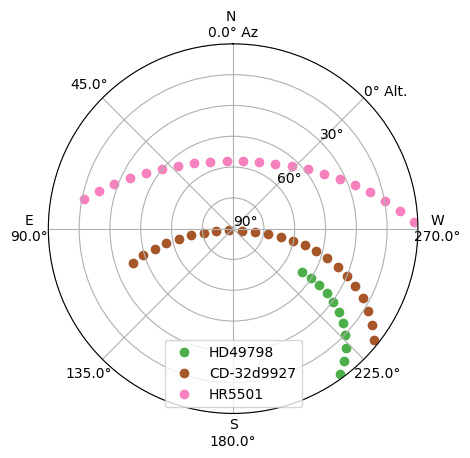

In [350]:
from astroplan.plots import plot_sky
from astroplan import Observer, FixedTarget

import matplotlib.pyplot as plt
from matplotlib import cm
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u


# Get grid of times within the time_range limits
from astroplan import time_grid_from_range

time_range = Time([time_window_start, time_window_start + 12 * u.hour])
time_grid = time_grid_from_range(time_range)

plt.figure(figsize=(6, 6))
cmap = cm.Set1  # Cycle through this colormap

for i, target in enumerate(filtered_spectral_standards_targets):

    if target.name in selected_rows:
        ax = plot_sky(
            target,
            SUTHERLAND_OBSERVATORY,
            time_grid,
            style_kwargs=dict(
                color=cmap(float(i) / len(filtered_spectral_standards_targets)),
                label=target.name,
            ),
        )
        legend = ax.legend(loc="lower center")
        legend.get_frame().set_facecolor("w")


plt.show()